# Setup

Select Platform

In [1]:
platform = 'jupyter_notebook' #@param ['colab', 'jupyter_notebook'] {allow-input: true}

Import Libraries

In [1]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt
from nilearn import datasets
from nilearn import plotting
import nibabel as nib
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision.models import AlexNet_Weights, VGG16_Weights, VGG16_BN_Weights
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression, Ridge
from scipy.stats import pearsonr as corr

Platform Definition (jupyter or colab)

In [3]:
if platform == 'jupyter_notebook':
    # data_dir = '../../../Projects/Datasets/Biomedical/algonauts_2023_challenge_data'
    # Data folder definition
    data_dir = '../../Datasets/Biomedical/algonauts_2023_challenge_data'
    # Used to save the prediction of saved model
    parent_submission_dir = '../algonauts_2023_challenge_submission'
    ncsnr_dir = '../../Datasets/Biomedical/algonauts_ncsnr'
    images_trials = '../../Datasets/Biomedical/algonauts_train_images_trials'

Select CPU or GPU and verify the selected device

In [4]:
device = 'cuda' #@param ['cpu', 'cuda'] {allow-input: true}
device = torch.device(device)

### Test CUDA and Pytorch

In [7]:
print(torch.cuda.is_available())

print(torch.cuda.device_count())

print(torch.cuda.current_device())

print(torch.cuda.device(0))

print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3070 Laptop GPU


In [20]:
print("Pytorch version：")
print(torch.__version__)
print("CUDA Version: ")
print(torch.version.cuda)
print("cuDNN version is :")
print(torch.backends.cudnn.version())

Pytorch version：
1.13.0
CUDA Version: 
11.6
cuDNN version is :
8302


# Data Loading

## Setup

To start, choose which of the 8 subjects you will use.

In [5]:
subj = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}

Let's define some paths that we will need for loading and storing data.

In [6]:
class argObj:
  def __init__(self, data_dir, parent_submission_dir, subj, parent_ncsnr_dir = ncsnr_dir, images_trials_parent_dir = images_trials):
    # Define the dir where data is stored
    # 1 became 01
    self.subj = format(subj, '02') # '0numberofchars'
    self.data_dir = os.path.join(data_dir, 'subj'+self.subj)

    # NCSNR
    self.parent_ncsnr_dir = parent_ncsnr_dir
    self.ncsnr_dir = os.path.join(self.parent_ncsnr_dir, 'subj'+self.subj)
    
    # SUBMISSION DIR
    self.parent_submission_dir = parent_submission_dir
    self.subject_submission_dir = os.path.join(self.parent_submission_dir,
        'subj'+self.subj)
    # Create the submission directory if not existing
    if not os.path.isdir(self.subject_submission_dir):
        os.makedirs(self.subject_submission_dir)

    # Train Images Trials 
    self.images_trials_parent_dir = images_trials_parent_dir
    self.images_trials_dir = os.path.join(self.images_trials_parent_dir, 'subj'+self.subj)
    
args = argObj(data_dir, parent_submission_dir, subj)

## fMRI Pre-processed Training Data

Load the fMRI response for the selected subject
- Response vectors are divided in left and right emisphere

In [7]:
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)


### Responses Exploration

In [33]:
print("Mean:", np.mean(lh_fmri))
print("Standard Deviation:", np.std(lh_fmri))
print("Variance:", np.var(lh_fmri))
print("Max:", np.max(lh_fmri))
print("Min:", np.min(lh_fmri))
print("Median:", np.median(lh_fmri))

Mean: 0.0016644258
Standard Deviation: 0.7087964
Variance: 0.50239235
Max: 6.3958163
Min: -5.5488534
Median: 0.0039879945


In [25]:
print(lh_fmri[:3, :3])

[[-0.8617882  -0.20318632 -0.62639767]
 [ 0.72242236 -0.2831422   0.92416   ]
 [-0.30844456 -0.9322294   1.7191527 ]]


## Stimulus Images

All images consist of natural scenes coming from the [COCO dataset][coco].

The images are divided into a training and a test split (corresponding to the fMRI training and test data splits). The amount of training and test images varies between subjects.

For more information on the images please see the [`README.txt`][readme] file accompanying the Challenge data.

[coco]: https://cocodataset.org/#home
[readme]: https://drive.google.com/file/d/16oLCaDmUBZuT6z_VGKO-qzwidYDE77Sg/view?usp=share_link

In [8]:
train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()
print('Training images: ' + str(len(train_img_list)))
print('Test images: ' + str(len(test_img_list)))

Training images: 9841
Test images: 159


The training and test images are stored in `.png` format. As an example, the first training image of subject 1 is named `train-0001_nsd-00013.png`.

The first index (`'train-0001'`) orders the images so to match the stimulus images dimension of the fMRI training split data. This indexing starts from 1.

The second index (`'nsd-00013'`) corresponds to the 73,000 NSD image IDs that you can use to map the image back to the [original `.hdf5` NSD image file][NSD_img_hdf5] (which contains all the 73,000 images used in the NSD experiment), and from there to the [COCO dataset][coco] images for metadata). The 73,000 NSD images IDs in the filename start from 0, so that you can directly use them for indexing the `.hdf5` NSD images in Python. Note that the images used in the NSD experiment (and here in the Algonauts 2023 Challenge) are cropped versions of the original COCO images. Therefore, if you wish to use the COCO image metadata you first need to adapt it to the cropped image coordinates. You can find code to perform this operation [here][coco_meta].

[NSD_img_hdf5]: https://cvnlab.slite.page/p/NKalgWd__F/Experiments
[coco]: https://cocodataset.org/#home
[coco_meta]: https://github.com/styvesg/nsd_gnet8x/blob/main/data_preparation.ipynb

### **NSD ID Extraction**

In [32]:
train_img_file = train_img_list[0]
print('Training image file name: ' + train_img_file)
print('73k NSD images ID: ' + train_img_file[-9:-4])

Training image file name: train-0001_nsd-00013.png
73k NSD images ID: 00013


# Train and Evaluate linearizing encoding models

Now you will build and evaluate [linearizing encoding models][encoding] using a pretrained [AlexNet][alexnet] architecture. You will train these models on the training partition and cross-validated them on the validation partition (an independent partition of the training data). The linearizing encoding algorithm involves the following steps:

1. Split the data into training, validation and test partitions.

2. Extract and downsample image features from AlexNet.

3. Linearly map the AlexNet image feature to fMRI responses. 

4. Evaluate and visualize the encoding model's prediction accuracy (i.e., encoding accuracy) using the validation partition.

You will use the test partition only in the final section of this tutorial, to prepare the Challenge submission files.

[encoding]: https://www.sciencedirect.com/science/article/pii/S1053811910010657
[alexnet]: https://arxiv.org/abs/1404.5997

## 2.1 Data

### 2.1.1 Create the training, validation and test partitions indices

Here you will create the indices to randomly split the training data into a training (90% of the data) and validation (10% of the data) partition. You can enforce different random splits by editing the random seed variable (`rand_seed`).

In [9]:
rand_seed = 5 #@param
np.random.seed(rand_seed)
train_percentage = 90

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(train_img_list) / 100 * train_percentage))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

Training stimulus images: 8857

Validation stimulus images: 984

Test stimulus images: 159


### 2.1.2 Create the training, validation and test image partitions DataLoaders

We will use the `Dataset` and `DataLoader` classes from PyTorch to create our training, validation and test image partitions. You can read more about these type of classes and how to use them [here][data_tutorial_pytorch].

Let's first define the preprocessing (transform) that will be applied to the images before feeding them to AlexNet. We will use a [standard preprocessing pipeline][preprocessing] as used in the computer vision literature.

[data_tutorial_pytorch]: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
[preprocessing]: https://pytorch.org/hub/pytorch_vision_alexnet/

**Preprocessing pipeline**

In [10]:
transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x224 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    # normalize the images color channels
    # mean: [0.485, 0.456, 0.406] for the three channels
    # std: [0.229, 0.224, 0.225] for the three channels
])

**Dataset class**: that will load, preprocess, and return an image at a time.

In [11]:
class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img

We will now create a **DataLoader class** that allow us to iterate over batches of images. We use batches because loading and processing all images at once uses too much memory.

In [12]:
# Create a list of 8000 zeros
batch_size_min = 300
batch_size_max = 350

for batch_size in range(batch_size_min, batch_size_max + 1):
    if len(train_img_list) % batch_size >= batch_size_min:
        print("Train images: ", len(train_img_list))
        print("Remainder: ", len(train_img_list) % batch_size)
        print("Batch size: ", batch_size)
        break

Train images:  9841
Remainder:  301
Batch size:  318


In [13]:
# batch_size = 300 # 300 #@param (310 for 3 and 6, 300 for others)
# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform), 
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform), 
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform), 
    batch_size=batch_size
)

### 2.1.3 Split the fMRI data into training and validation partitions

Here we will use the previously defined indices to split the training fMRI data into a training and validation partition.

In [14]:
lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]

Let's delete the original fMRI training split to free up RAM.

In [30]:
del lh_fmri, rh_fmri

## 2.2 Extract and downsample image features from AlexNet

In this step we will extract image features from a pretrained AlexNet, and downsample them to 100 PCA components to speed up computations in the the next encoding step (mapping of AlexNet feature onto fMRI features).

### 2.2.1 Load the pretrained AlexNet

We will load the pretrained AlexNet from the [PyTorch Hub][pytorch_hub] and set it to evaluation mode since we will not be training this network.

[pytorch_hub]: https://pytorch.org/hub/

In [15]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights=AlexNet_Weights.IMAGENET1K_V1)
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it

Using cache found in C:\Users\giorg/.cache\torch\hub\pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

AlexNet is composed of 5 convolutional layers (contained in a submodule called 'features') and 3 linear layers (contained in a submodule named 'classifier').

First let's print the AlexNet layer names of the PyTorch implementation.

In [18]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


### 2.2.2 Extract and downsample the AlexNet features

We will now extract the image features of an AlexNet layer of your choice, and reduce their size using PCA.

To extract the features, we will use the PyTorch function [`create_feature_extractor`][extract_feat].

1. First, choose the AlexNet layer you wish to use.
   -  The base choice is `features.2` → which correspond to the **MaxPool Layer of the FIrst Convolutional Block**
   - `(2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)`

[extract_feat]: https://pytorch.org/vision/stable/feature_extraction.html

In [16]:
model_layer = "features.12" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(model, return_nodes=[model_layer])

The size of the feature vectors we want to extract is very large, so we will use a dimensionality reduction technique (in this case PCA) to overcome this problem. We will fit the PCA on the training images features, and use it to downsample the training, validation and test images features.

In an *ideal scenario with no RAM limitations, we would compute the PCA and transform all images of the training set simultaneously*. Since we do have this restriction, we will do a **batch-wise partial computation of the PCA** (see [`IncrementalPCA`][pca] for more info).

The following function extracts the AlexNet features from each image batch, and partially computes the PCA.

[pca]: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html

In [17]:
def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=100, batch_size=batch_size)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca

Let's fit the PCA on the training partition images features. This step can take longer or shorter depending on the AlexNet layer you chose to use for the encoding, and on your computing resources. 

In [19]:
pca = fit_pca(feature_extractor, train_imgs_dataloader)

100%|██████████| 28/28 [02:29<00:00,  5.35s/it]


Now that we fitted our PCA model, we will use it do reduce the dimensionality of the training, validation and test images features.

Unfortunately, due to memory limits we will have to extract the AlexNet image features from each batch again to downsample them.

In [20]:
def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)

In [21]:
features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


In [22]:
print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_val.shape)
print('(Validation stimulus images × PCA features)')

print('\nTest images features:')
print(features_test.shape)
print('(Test stimulus images × PCA features)')


Training images features:
(8857, 100)
(Training stimulus images × PCA features)

Validation images features:
(984, 100)
(Validation stimulus images × PCA features)

Test images features:
(159, 100)
(Test stimulus images × PCA features)


Let's free up RAM by deleting the AlexNet model and PCA parameters.

In [23]:
del model, pca

### Load the pre-trained efficient-netb2

In [ ]:
from torchvision.models import EfficientNet_B2_Weights
from torchvision import models
model = models.efficientnet_b2(weights = EfficientNet_B2_Weights.IMAGENET1K_V1)
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it


In [6]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

['x', 'features.0', 'features.1.0.block.0', 'features.1.0.block.1', 'features.1.0.block.2', 'features.1.1.block.0', 'features.1.1.block.1', 'features.1.1.block.2', 'features.1.1.stochastic_depth', 'features.1.1.add', 'features.2.0.block.0', 'features.2.0.block.1', 'features.2.0.block.2', 'features.2.0.block.3', 'features.2.1.block.0', 'features.2.1.block.1', 'features.2.1.block.2', 'features.2.1.block.3', 'features.2.1.stochastic_depth', 'features.2.1.add', 'features.2.2.block.0', 'features.2.2.block.1', 'features.2.2.block.2', 'features.2.2.block.3', 'features.2.2.stochastic_depth', 'features.2.2.add', 'features.3.0.block.0', 'features.3.0.block.1', 'features.3.0.block.2', 'features.3.0.block.3', 'features.3.1.block.0', 'features.3.1.block.1', 'features.3.1.block.2', 'features.3.1.block.3', 'features.3.1.stochastic_depth', 'features.3.1.add', 'features.3.2.block.0', 'features.3.2.block.1', 'features.3.2.block.2', 'features.3.2.block.3', 'features.3.2.stochastic_depth', 'features.3.2.a

### Load the pre-trained VGG-16

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 
                        'vgg16_bn', 
                        weights=VGG16_BN_Weights.IMAGENET1K_V1)
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it

Using cache found in C:\Users\giorg/.cache\torch\hub\pytorch_vision_v0.10.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [8]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'features.31', 'features.32', 'features.33', 'features.34', 'features.35', 'features.36', 'features.37', 'features.38', 'features.39', 'features.40', 'features.41', 'features.42', 'features.43', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 
                        'vgg16', 
                        weights=VGG16_Weights.IMAGENET1K_V1)
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it

In [6]:
from torchvision.models import VGG19_Weights
model = torch.hub.load('pytorch/vision:v0.10.0', 
                        'vgg19', 
                        weights=VGG19_Weights.IMAGENET1K_V1)
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it

Using cache found in C:\Users\giorg/.cache\torch\hub\pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\giorg/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Test PCA specifiyng explained variance percentage

In [33]:
def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=0.30, batch_size=batch_size)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca

In [ ]:
pca = fit_pca(feature_extractor, train_imgs_dataloader)

In [35]:
print("Comulative Explained variance ratio: ", sum(pca.explained_variance_ratio_))
print("Number of components: ", pca.n_components_)

Comulative Explained variance ratio:  0.39269976662655187
Number of components:  100


In [28]:
sum(pca.explained_variance_ratio_)

0.39269976662655187

## Linearly map the AlexNet image features to fMRI responses + compute pearson correlation


In [24]:
# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)

In [238]:
# Explore the numpy arrays
print(lh_fmri_val_pred.shape)

# Print summary statistics on lh_fmri_val_pred
print('Mean: ' + format(np.mean(lh_fmri_val_pred)))
print('Standard deviation: ' + format(np.std(lh_fmri_val_pred)))
print('Minimum: ' + format(np.min(lh_fmri_val_pred)))
print('Maximum: ' + format(np.max(lh_fmri_val_pred)))
print('Median: ' + format(np.median(lh_fmri_val_pred)))
print('25th percentile: ' + format(np.percentile(lh_fmri_val_pred, 25)))
print('75th percentile: ' + format(np.percentile(lh_fmri_val_pred, 75)))


(908, 19004)
Mean: 0.00526684624765987
Standard deviation: 0.2042430403708923
Minimum: -1.573190950137589
Maximum: 1.8854053635788137
Median: 0.0017901554197446686
25th percentile: -0.10286238085740623
75th percentile: 0.11017703774850804


### Grid Search + Cross Validate

#### Grid Search

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr
import numpy as np

In [ ]:
param_grid = {'alpha': [0.0001, 0.0002, 0.001, 0.01, 0.1, 1, 10, 100, 1e4, 2e4, 5e4, 1e5]}

In [ ]:
def compute_perason_numpy(pred, target):

    corrcoef = list()
    for pred, target in zip(pred.T, target.T):

        s, _ = pearsonr(x=pred, y=target)
        corrcoef.append(s)

    return np.array(corrcoef)

In [37]:
grid_search_l = GridSearchCV(Ridge(), param_grid=param_grid, scoring=make_scorer(
    lambda x, y: np.median(compute_perason_numpy(x, y))), cv=5, n_jobs=5, verbose=1)
grid_search_l.fit(X=features_train, y=lh_fmri_train)
print("Best Param: {}".format(grid_search_l.best_params_))
print("Best Score: {}".format(grid_search_l.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Param: {'alpha': 100000.0}
Best Score: 0.4003252882147619


In [39]:
print("Best Param: {}".format(grid_search_l.best_params_))
print("Best Score: {}".format(grid_search_l.best_score_))

Best Param: {'alpha': 100000.0}
Best Score: 0.4003252882147619


In [ ]:
grid_search_l.cv_results_

In [41]:
grid_search_r = GridSearchCV(Ridge(), param_grid=param_grid, scoring=make_scorer(
    lambda x, y: np.median(compute_perason_numpy(x, y))), cv=5, n_jobs=5, verbose=1)
grid_search_r.fit(X=features_train, y=rh_fmri_train)
print("Best Param: {}".format(grid_search_r.best_params_))
print("Best Score: {}".format(grid_search_r.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Param: {'alpha': 100000.0}
Best Score: 0.40087493401053653


In [ ]:
grid_search_r.cv_results_

#### Cross Validate

In [44]:
model_l = cross_validate(Ridge(alpha=1e4), X=features_train, y=lh_fmri_train, cv=5, n_jobs=5,
                         scoring=make_scorer(lambda x, y: np.median(compute_perason_numpy(x, y))), verbose=1)

for k, v in model_l.items():
    print("<{}>:\t{}".format(k, ",\t".join(["{:.3f}".format(x) for x in v])))

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   15.6s remaining:   23.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   15.7s finished


<fit_time>:	6.887,	7.227,	6.981,	7.071,	7.119
<score_time>:	8.284,	7.967,	8.241,	8.177,	8.139
<test_score>:	0.394,	0.403,	0.399,	0.399,	0.396


In [45]:
model_r = cross_validate(Ridge(alpha=1e4), X=features_train, y=rh_fmri_train, cv=5, n_jobs=5,
                         scoring=make_scorer(lambda x, y: np.median(compute_perason_numpy(x, y))), verbose=1)

for k, v in model_r.items():
    print("<{}>:\t{}".format(k, ",\t".join(["{:.3f}".format(x) for x in v])))

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   15.5s remaining:   23.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   15.7s finished


<fit_time>:	7.741,	7.713,	7.818,	7.778,	7.813
<score_time>:	7.520,	7.358,	7.281,	7.480,	7.363
<test_score>:	0.394,	0.406,	0.400,	0.398,	0.396


### Compute the encoding accuracy through a Pearson's correlation

Here you will compute your encoding model's prediction accuracy (or encoding accuracy) through a Pearson correlation between the predicted and ground truth fMRI validation partition data. The correlation scores indicate how similar the predicted fMRI data is to the ground truth data, namely how accurate your encoding model is in predicting (encoding) fMRI responses to images.

Specifically, you will correlate the activity of each predicted fMRI vertex with the activity of the corresponding ground truth fMRI vertex, across the validation partition stimulus images.

In [25]:
# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0] # 0 per selezionare valore e non p-value

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]

100%|██████████| 20544/20544 [00:01<00:00, 11119.09it/s]


#### Exploration

In [33]:
import pandas as pd
row_labels = ['img'+str(i+1) for i in range(lh_fmri_val.shape[0])]
col_labels = ['v'+str(i+1) for i in range(lh_fmri_val.shape[1])]

# Creazione del DataFrame
fmri_val_df = pd.DataFrame(lh_fmri_val, index=row_labels, columns=col_labels)
fmri_val_df

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v18995,v18996,v18997,v18998,v18999,v19000,v19001,v19002,v19003,v19004
img1,-1.362684,0.105403,-0.634885,1.116996,-1.146858,-0.142268,-0.450975,-0.201355,-1.020084,-1.626789,...,0.456325,0.285525,-0.036011,-0.006968,-0.372848,-0.372848,-0.203140,-0.107464,-0.016841,-0.391263
img2,-0.755504,-0.152065,-0.998677,-0.694289,-0.747618,-0.024071,-0.754630,-0.922632,-1.615000,0.043055,...,1.297180,1.459296,1.025424,1.005834,0.723775,0.723775,-0.095860,0.136672,0.148448,0.380446
img3,0.864619,0.136462,-0.621923,0.023420,-1.307619,-0.460672,1.176813,-1.424946,0.715326,-0.628299,...,-0.001527,-0.010651,0.345488,0.391329,0.307540,0.307540,-0.494696,-0.472332,-0.482341,-0.727570
img4,1.017041,-1.972292,0.777953,0.681789,0.483763,0.744049,0.799378,1.427946,0.780410,0.517839,...,-0.145668,-0.158004,-0.662477,-0.014418,-0.469669,-0.469669,-0.132624,-0.466943,-0.257576,0.203096
img5,0.468452,0.146705,-0.446328,1.134242,0.489677,0.092135,0.812579,-0.042108,0.319703,0.822444,...,-0.082524,-0.621402,0.014672,0.275363,-0.293559,-0.293559,-0.402352,-0.426450,-0.489094,-0.634863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
img980,-0.232234,-0.299230,0.065471,0.992445,-0.598850,0.041030,0.742306,-0.892351,-0.500703,-0.486626,...,-0.005898,0.332630,0.334730,-0.358881,-0.936860,-0.936860,-0.240730,-0.313589,-0.234719,0.337383
img981,0.075665,-0.148535,-0.708590,-0.623013,0.364155,-0.745957,1.450083,-1.272296,-0.610939,1.130801,...,-0.205289,-0.162905,-0.367591,-0.564725,-0.362926,-0.362926,-0.209540,-0.804745,-0.727909,-0.005451
img982,-0.686496,-0.551945,-2.309315,-0.965421,-0.944869,-1.542230,-0.031113,-1.798432,-0.525722,-0.456545,...,-0.980871,-0.678518,-0.724203,-0.629889,-0.163823,-0.163823,-0.931302,-0.667792,-0.594068,-0.201914
img983,-0.119940,0.083208,0.310171,1.142716,0.038672,-0.325022,0.788824,0.684125,-0.362595,0.128404,...,-1.395679,-1.675182,-1.117538,-0.559994,0.343039,0.343039,-0.209873,-0.123184,-0.179543,-0.510203


In [32]:
import pandas as pd
row_labels = ['img'+str(i+1) for i in range(lh_fmri_val_pred.shape[0])]
col_labels = ['v'+str(i+1) for i in range(lh_fmri_val_pred.shape[1])]

# Creazione del DataFrame
fmri_val_pred_df = pd.DataFrame(lh_fmri_val_pred, index=row_labels, columns=col_labels)
fmri_val_pred_df

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v18995,v18996,v18997,v18998,v18999,v19000,v19001,v19002,v19003,v19004
img1,-0.290258,-0.260766,0.398556,0.551459,0.203292,0.350700,0.090883,0.560466,0.076039,-0.470655,...,-0.197475,-0.260196,-0.135420,-0.090778,-0.017567,-0.017567,-0.084397,-0.254089,-0.320621,-0.044061
img2,-0.231810,-0.086052,-0.523469,-0.638392,-0.316659,0.054627,-0.208353,-0.894260,-0.325251,-0.335083,...,0.265778,0.319153,0.250359,0.200973,0.152748,0.152748,0.009740,0.038726,0.053515,0.055127
img3,0.167813,0.094185,0.182432,-0.162009,-0.086838,0.256734,-0.065228,-0.337406,-0.042966,-0.421225,...,0.337032,0.353427,0.318367,0.299446,0.242927,0.242927,0.316172,0.378080,0.363827,0.152742
img4,0.179203,0.060119,-0.010540,0.228525,0.077062,0.064330,0.343766,0.627719,0.007319,-0.000853,...,0.059600,0.089175,0.078179,0.075996,0.071723,0.071723,-0.008810,0.030115,0.040529,0.010019
img5,0.304406,0.443552,0.005249,0.065611,-0.039035,0.138633,0.044665,-0.205013,-0.339522,0.008705,...,0.382797,0.463299,0.298858,0.198986,0.101586,0.101586,0.114196,0.156807,0.192245,-0.022523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
img980,-0.049621,-0.194991,-0.377691,-0.117684,-0.192404,-0.226072,-0.064908,-0.176825,-0.045374,-0.143872,...,-0.037360,-0.060519,-0.017378,-0.001417,0.031624,0.031624,-0.009529,0.005759,0.002183,0.072564
img981,-0.051303,-0.079236,-0.621526,-0.791669,-0.165708,-0.275625,-0.062718,-0.615584,0.181013,0.181578,...,0.062214,0.054557,0.067791,0.023669,-0.030190,-0.030190,-0.025124,-0.154573,-0.176024,-0.111984
img982,0.026921,-0.110675,-1.328202,-0.824288,-0.489548,-0.511362,0.156399,-1.129562,0.256481,0.513830,...,-0.255496,-0.145004,-0.229646,-0.270375,-0.281994,-0.281994,-0.473573,-0.484659,-0.413436,-0.319208
img983,0.154602,0.323428,0.574714,0.690337,0.180027,-0.063628,0.121437,0.386864,-0.322702,-0.039456,...,0.020442,0.034058,0.000138,-0.028001,-0.007571,-0.007571,0.134924,0.232575,0.249692,-0.005120


In [27]:
print(lh_correlation[:5], "Shape: ", lh_correlation.shape)

[0.30821148 0.36844289 0.58986917 0.55375606 0.25530387] Shape:  (19004,)


In [42]:
lh_correlation.shape

(19004,)

### Prepare submission files

First, you need to convert your predicted fMRI responses to `float32` data type. This is important, since the maximum submission size is 300MB, and a `float64` data type would exceed this limit.

In [95]:
lh_fmri_val_pred = lh_fmri_val_pred.astype(np.float32)
rh_fmri_val_pred = rh_fmri_val_pred.astype(np.float32)

Finally, save the predicted fMRI responses to the test images in the subject-specific submission directory that we created previously (`../algonauts_2023_challenge_submission/subj0X/`), where `'X'` goes from `'1'` to `'8'`), with separate files for the predictions of each hemisphere: `lh_pred_test.npy` for the left hemisphere and `rh_pred_test.npy` for the right hemisphere.

<font color='red'><b>NOTE:</b></font> these files need to contain the predicted brain responses of all vertices, and not of any ROI.

In [96]:
np.save(os.path.join(args.subject_submission_dir, 'lh_pred_val.npy'), lh_fmri_val_pred)
np.save(os.path.join(args.subject_submission_dir, 'rh_pred_val.npy'), rh_fmri_val_pred)

## Evaluate the model

To start, choose which of the 8 subjects you will use.

In [7]:
subj = 6 #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}

Let's define some paths that we will need for loading and storing data.

In [8]:
class argObj:
  def __init__(self, data_dir, parent_submission_dir, subj):
    # Define the dir where data is stored
    # 1 became 01
    self.subj = format(subj, '02') # '0numberofchars'
    self.data_dir = os.path.join(data_dir, 'subj'+self.subj)
    self.parent_submission_dir = parent_submission_dir
    self.subject_submission_dir = os.path.join(self.parent_submission_dir,
        'subj'+self.subj)

    # Create the submission directory if not existing
    if not os.path.isdir(self.subject_submission_dir):
        os.makedirs(self.subject_submission_dir)

In [41]:
correlation = np.empty(0)
for subj in tqdm(range(1, 9), total=len(range(1, 9))):
    args = argObj(data_dir, parent_submission_dir, subj)
    
    train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
    train_img_list = os.listdir(train_img_dir)
    train_img_list.sort()
    
    rand_seed = 5 #@param
    np.random.seed(rand_seed)

    # Calculate how many stimulus images correspond to 90% of the training data
    num_train = int(np.round(len(train_img_list) / 100 * 90))
    # Shuffle all training stimulus images
    idxs = np.arange(len(train_img_list))
    np.random.shuffle(idxs)
    # Assign 90% of the shuffled stimulus images to the training partition,
    # and 10% to the test partition
    idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
    
    fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
    lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
    rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))
    lh_fmri = lh_fmri[idxs_val]
    rh_fmri = rh_fmri[idxs_val]
    
    lh_pred_fmri = np.load(os.path.join(args.subject_submission_dir,"lh_pred_val.npy"))
    rh_pred_fmri = np.load(os.path.join(args.subject_submission_dir,"rh_pred_val.npy"))

    # print(f'Subj{subj} - LH training fMRI data shape:')
    # print(lh_fmri.shape)
    # print(lh_pred_fmri.shape)
    # print('(Training stimulus images × LH vertices)')

    # print(f'Subj{subj} - \nRH training fMRI data shape:')
    # print(rh_fmri.shape)
    # print(rh_pred_fmri.shape)
    # print('(Training stimulus images × RH vertices)')
    
    # Empty correlation array of shape: (LH vertices)
    lh_correlation = np.zeros(lh_pred_fmri.shape[1])
    # Correlate each predicted LH vertex with the corresponding ground truth vertex
    for v in range(lh_pred_fmri.shape[1]):
        lh_correlation[v] = corr(lh_pred_fmri[:,v], lh_fmri[:,v])[0] # 0 per selezionare valore e non p-value

    correlation = np.append(correlation, lh_correlation)
    # Empty correlation array of shape: (RH vertices)
    rh_correlation = np.zeros(rh_pred_fmri.shape[1])
    # Correlate each predicted RH vertex with the corresponding ground truth vertex
    for v in range(rh_pred_fmri.shape[1]):
        rh_correlation[v] = corr(rh_pred_fmri[:,v], rh_fmri[:,v])[0]
    correlation = np.append(correlation, rh_correlation)

100%|██████████| 8/8 [00:28<00:00,  3.59s/it]


In [46]:
print(correlation.shape)
print(np.median(correlation))

(315997,)
0.17844173747681108


In [ ]:
for subj in range(1, 9):
    args = argObj(data_dir, parent_submission_dir, subj)
    fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
    lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
    rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

    print(f'Subj{subj} - LH training fMRI data shape:')
    print(lh_fmri.shape)
    #print('(Training stimulus images × LH vertices)')

    print(f'Subj{subj} - \nRH training fMRI data shape:')
    print(rh_fmri.shape)
    #print('(Training stimulus images × RH vertices)')

In [101]:
# Creo una lista con i nomi delle cartelle
folders = ["subj01", "subj02", "subj03", "subj04", "subj05", "subj06", "subj07", "subj08"]
# Itero sulla lista
for folder in folders:
  # Costruisco i percorsi dei file da importare
  lh_file = parent_submission_dir + "/" + folder + "/lh_pred_val.npy"
  rh_file = parent_submission_dir + "/" + folder + "/rh_pred_val.npy"
  # Carico i file come matrici numpy
  lh_matrix = np.load(lh_file)
  rh_matrix = np.load(rh_file)
  # Stampo le dimensioni delle matrici
  print("Dimensioni della matrice lh per", folder, ":", np.shape(lh_matrix))
  print("Dimensioni della matrice rh per", folder, ":", np.shape(rh_matrix))

Dimensioni della matrice lh per subj01 : (984, 19004)
Dimensioni della matrice rh per subj01 : (984, 20544)
Dimensioni della matrice lh per subj02 : (984, 19004)
Dimensioni della matrice rh per subj02 : (984, 20544)
Dimensioni della matrice lh per subj03 : (908, 19004)
Dimensioni della matrice rh per subj03 : (908, 20544)
Dimensioni della matrice lh per subj04 : (878, 19004)
Dimensioni della matrice rh per subj04 : (878, 20544)
Dimensioni della matrice lh per subj05 : (984, 19004)
Dimensioni della matrice rh per subj05 : (984, 20544)
Dimensioni della matrice lh per subj06 : (908, 18978)
Dimensioni della matrice rh per subj06 : (908, 20220)
Dimensioni della matrice lh per subj07 : (984, 19004)
Dimensioni della matrice rh per subj07 : (984, 20544)
Dimensioni della matrice lh per subj08 : (878, 18981)
Dimensioni della matrice rh per subj08 : (878, 20530)


# Evaluate the model (2)

You are right, the tutorial only goes as far as calculating the Pearson's correlation between the predicted and ground truth fMRI responses. This is because the Challenge data release didn't include the ncsnr, which is necessary to compute the noise normalized encoding accuracy (the official Challenge evaluation metric).

You can download the ncsnr from the AWS NSD data release (/natural-scenes-dataset/nsddata_betas/ppdata/subj0X/fsaverage/betas_fithrf_GLMdenoise_RR/Xh.ncsnr.mgh), and then index the vertices retained for the Challenge using the vertices mask we provide in the Challenge data release (/algonauts_2023_challenge_data/subj0X/roi_masks/Xh.all-vertices_fsaverage_space.npy)

Once you have the ncsnr of the Challenge vertices, you will have to transform it into the noise ceiling based on how many trials exist (from 1 to 3) for each of the image conditions you will use to evaluate your models (i.e., the images of the Challenge train split on which you will evaluate your models). However, you cannot infer the trial number of each image condition from the Challenge data, as this data is averaged across trials of each image condition. Here you will find a vector variable for each Challenge subject indicating how many trials (from 1 to 3) were averaged to obtain the fMRI responses for each image condition of the Challenge train split. For the transformation from ncsnr to noise ceiling, please use the last equation of the "Noise ceiling" paragraph in the "Functional data (NSD)" section of the NSD data manual.

Finally, once you have the noise ceiling, you can use it to calculate the noise normalized encoding accuracy (the code attached to this email is what we use to compute the Challenge evaluation metric).


## Importing ncsnr

In [42]:
from nibabel.freesurfer.mghformat import load

In [43]:
lh_ncsnr = load(os.path.join(args.ncsnr_dir, 'lh.ncsnr.mgh'))
rh_ncsnr = load(os.path.join(args.ncsnr_dir, 'rh.ncsnr.mgh'))

Extract the ncsnr numpy 1D vector from the MGHImage object

In [44]:
lh_ncsnr_all_vertices = lh_ncsnr.get_fdata()[:,0,0]
rh_ncsnr_all_vertices = rh_ncsnr.get_fdata()[:,0,0]

### Data exploration

In [33]:
type(lh_ncsnr)

nibabel.freesurfer.mghformat.MGHImage

In [34]:
lh_ncsnr.shape

(163842, 1, 1)

In [38]:
lh_ncsnr_all_vertices.shape

(163842,)

In [45]:
print(lh_ncsnr.get_fdata()[:,0,0], "shape", lh_ncsnr.get_fdata()[:,0,0].shape)

[0.11920288 0.31043354 0.11843289 ... 0.03596502 0.03923279 0.11306294] shape (163842,)


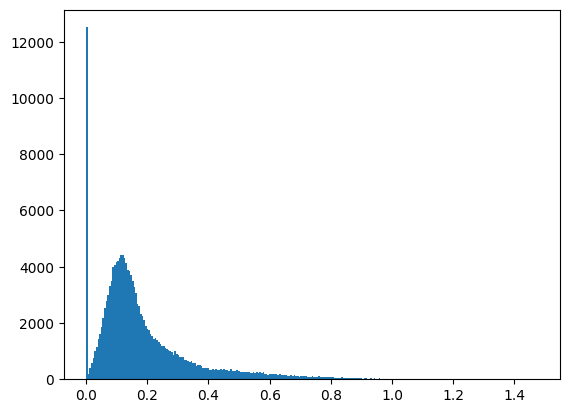

In [71]:
_ = plt.hist(lh_ncsnr_all_vertices, bins='auto')
plt.show()

## Importing fsaverage 


`Xh.all-vertices_fsaverage_space.npy` is a vertices mask that associate to every of the 163842 vertices of the `fsaverage_space` a value of 1 if it is part of the `challenge space` and 0 if it is not. 

In [46]:
hemisphere = ['left', 'right'] #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0][0]+'h.all-vertices_fsaverage_space.npy')
lh_fsaverage_all_vertices = np.load(roi_dir)

roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[1][0]+'h.all-vertices_fsaverage_space.npy')
rh_fsaverage_all_vertices = np.load(roi_dir)

### Exploring the data

In [47]:
lh_fsaverage_all_vertices.shape

(163842,)

How to extract indicies of vertices in the challenge space from the fsaverage space:

In [46]:
np.where(lh_fsaverage_all_vertices)[0]

array([     6,      7,     32, ..., 163061, 163062, 163063], dtype=int64)

In [47]:
len(np.where(lh_fsaverage_all_vertices)[0])

19004

Altro

In [19]:
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')

In [22]:
type(fsaverage)

sklearn.utils._bunch.Bunch

In [35]:
fsaverage.keys()

dict_keys(['area_left', 'area_right', 'curv_left', 'curv_right', 'infl_left', 'infl_right', 'pial_left', 'pial_right', 'sphere_left', 'sphere_right', 'sulc_left', 'sulc_right', 'thick_left', 'thick_right', 'white_left', 'white_right', 'description'])

## Extract ncsnr for vertices in the challenge space

In [48]:
lh_ncsnr_challenge_vertices = lh_ncsnr_all_vertices[np.where(lh_fsaverage_all_vertices)[0]]
rh_ncsnr_challenge_vertices = rh_ncsnr_all_vertices[np.where(rh_fsaverage_all_vertices)[0]]

In [14]:
print(lh_ncsnr_challenge_vertices[:5], "shape", lh_ncsnr_challenge_vertices.shape)

[0.45753199 0.30325422 0.69066209 1.016029   0.27059516] shape (19004,)


In [41]:
np.mean(lh_ncsnr_challenge_vertices)

0.501568849998995

## Import images number of trial (needed to compute Noise Ceiling) for the ENTIRE training set

In [49]:
image_trial_number = np.load(os.path.join(args.images_trials_dir, 'train_images_trials.npy'))

### Exploring the data

In [31]:
print(image_trial_number, "shape", image_trial_number.shape)


[3 3 3 ... 3 3 3] shape (9841,)


In [32]:
image_trial_number.shape

(9841,)

<function matplotlib.pyplot.show(close=None, block=None)>

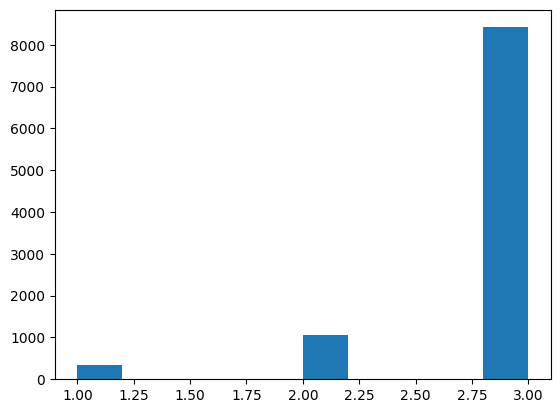

In [53]:
plt.hist(image_trial_number)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

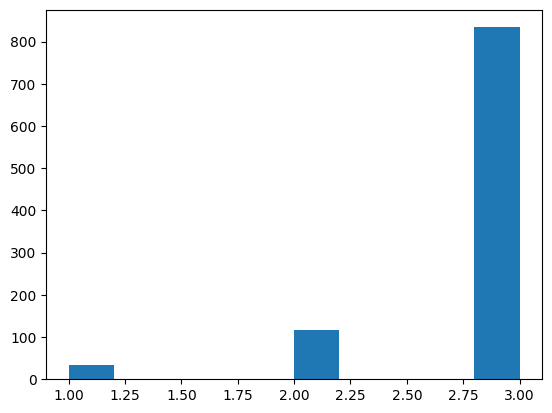

In [33]:
plt.hist(image_trial_number[idxs_val])
plt.show

## Find the number of trials for the validation set only

In [50]:
image_trial_number_val = image_trial_number[idxs_val]

## Compute Noise Ceilings (NC)

Defining:
- A = number of images with 3 trials
- B = number of images with 2 trials
- C = numebr of images with 1 trial

In [51]:
A = len(image_trial_number_val[image_trial_number_val == 3])
B = len(image_trial_number_val[image_trial_number_val == 2])
C = len(image_trial_number_val[image_trial_number_val == 1])

print(A, B, C)

834 117 33


Compute Noice Ceiling

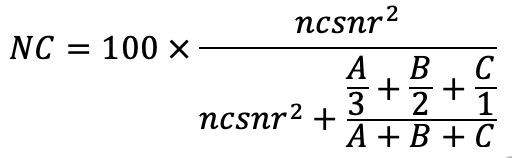

In [52]:
lh_noise_ceiling = (lh_ncsnr_challenge_vertices ** 2) / ((lh_ncsnr_challenge_vertices ** 2) + ((A/3 + B/2 + C/1) / (A + B + C)))
rh_noise_ceiling = (rh_ncsnr_challenge_vertices ** 2) / ((rh_ncsnr_challenge_vertices ** 2) + ((A/3 + B/2 + C/1) / (A + B + C)))

### NC exploration

In [56]:
print(lh_ncsnr_challenge_vertices[:5], "shape", lh_noise_ceiling.shape)

[0.45753199 0.30325422 0.69066209 1.016029   0.27059516] shape (19004,)


In [57]:
print(lh_noise_ceiling[:5], "shape", lh_noise_ceiling.shape)

[0.38257236 0.21396401 0.58539575 0.75342749 0.17812687] shape (19004,)


In [52]:
np.mean(lh_noise_ceiling)
np.mean(lh_noise_ceiling)

0.3814481862765162

## Compute NOISE NORMALIZED SQUARED CORRELATION

Set negative correlation values to 0, so to keep the noise-normalized encoding accuracy positive

In [37]:
lh_correlation[lh_correlation<0] = 0
rh_correlation[rh_correlation<0] = 0

Square the correlation values

In [38]:
lh_correlation = lh_correlation ** 2
rh_correlation = rh_correlation ** 2

In [40]:
print(lh_correlation[:5], "shape", lh_correlation.shape)

[0.09499432 0.13575016 0.34794564 0.30664577 0.06518006] shape (19004,)


Add a very small number to noise ceiling values of 0, otherwise the noise-normalized encoding accuracy cannot be calculated (division by 0 is not possible)

In [53]:
lh_noise_ceiling[lh_noise_ceiling==0] = 1e-14
rh_noise_ceiling[rh_noise_ceiling==0] = 1e-14

In [56]:
print(lh_noise_ceiling[:5], "shape", lh_noise_ceiling.shape)

[0.35793416 0.19672465 0.55953275 0.73327037 0.16317555] shape (19004,)


Compute the noise-normalized encoding accuracy

In [54]:
lh_noise_norm_corr = np.divide(lh_correlation, lh_noise_ceiling)
rh_noise_norm_corr = np.divide(rh_correlation, rh_noise_ceiling)

In [55]:
print(lh_noise_norm_corr[:5], "shape", lh_noise_norm_corr.shape)

[0.26539606 0.6900516  0.62185036 0.41818923 0.3994475 ] shape (19004,)


Set the noise-normalized encoding accuracy to 1 (100% accuracy) for those vertices in which the correlation is higher than the noise ceiling, to prevent encoding accuracy values higher than 100%

In [253]:
lh_noise_norm_corr[lh_noise_norm_corr>1] = 1
rh_noise_norm_corr[rh_noise_norm_corr>1] = 1

Compute **median noise normalized squared correlation (in this EXAMPLE only for the singles emispheres)**

In [254]:
print(np.median(lh_noise_norm_corr))
print(np.median(rh_noise_norm_corr))
print(np.mean(lh_noise_norm_corr))
print(np.mean(rh_noise_norm_corr))

0.1407182913703659
0.1262181866791165
0.18697322868340183
0.1670923019675932


### Exploration

In [267]:
noise_norm_corr_dict = {}
noise_norm_corr_dict[f'lh_{subj}'] = lh_noise_norm_corr
noise_norm_corr_dict[f'rh_{subj}'] = rh_noise_norm_corr
for key, value in noise_norm_corr_dict.items():
    print("Subject ->",key,"| Median Noise Normalized Squared Correlation Percentage ->",np.median(value)*100)

Subject -> lh_3 | Median Noise Normalized Squared Correlation Percentage -> 14.07182913703659
Subject -> rh_3 | Median Noise Normalized Squared Correlation Percentage -> 12.621818667911649


In [268]:
concatenated_array = np.concatenate(list(noise_norm_corr_dict.values()))
median = np.median(concatenated_array)

print(median)

0.1330357811214621


In [270]:
print(range(1, 9))

range(1, 9)
